In [1]:
from GG_mthesis import *
import metpy
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
%matplotlib inline

# sns.set_style('whitegrid')
# sns.set_palette('colorblind')
# sns.set(font_scale=1.2)

# Loading CTD casts

In [2]:
path1 = 'data/01_raw/ctd_orchestra/b1841282.nc'
path2 = 'data/01_raw/ctd_orchestra/b1841294.nc'
ds1 = xr.open_dataset(path1)
ds2 = xr.open_dataset(path2)
ds = xr.concat([ds1.isel(MAXZ=slice(0,1500)), ds2.isel(MAXZ=slice(0,1500))],dim='cast')

In [3]:
aux = None

In [4]:
ds3 = xr.open_dataset('data/01_raw/ctd_orchestra/b1841301.nc')
ds_new = xr.concat([ds, ds3.isel(MAXZ=slice(0,1500))],dim='cast')

In [5]:
ds = ds1.isel(MAXZ=slice(0,1500)).squeeze().drop_dims('REFMAX')
directory = 'data/01_raw/ctd_orchestra'
for filename in os.listdir(directory):
    filepath = directory + '/' + filename
    if filename.endswith('.nc'):
        ds_new = xr.open_dataset(filepath).isel(MAXZ=slice(0,1500)).squeeze().drop_dims('REFMAX')
        ds = xr.concat([ds, ds_new],dim='N_profile')
    else:
        continue

In [6]:
#finish this later but 
# def load_ctd_casts(path):
#     ds = xr.open_dataset
#     import xarray as xr
#     import os
#     global data
#     ds = xr.open_dataset()
#     for filename in os.listdir(directory):
#         filepath = directory + '/' + filename
#         if filename.endswith('.nc'):
#             ds = xr.open_dataset(filepath)
#             index = os.listdir(directory).index(filename)
#             data[index] = ds
#         else:
#             continue
#     return data

# Plotting cast locations

C:\Users\gian_\AppData\Local\Temp/ipykernel_6820/800236021.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  c=mdates.date2num(ds.swap_dims({'N_profile':'TIME'}).indexes['TIME'].to_datetimeindex()) ,


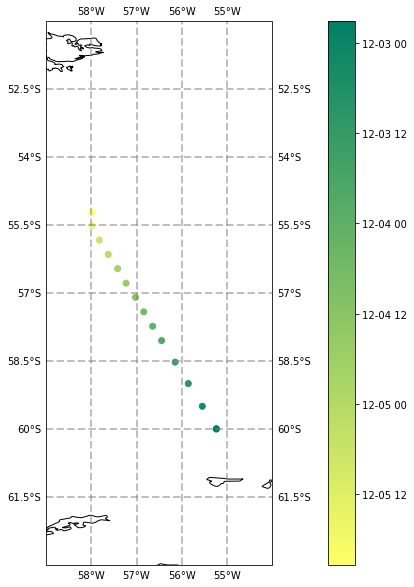

In [7]:
import matplotlib.dates as mdates

fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))

ax.set_extent([-59,-54,-63,-51])
sc = plt.scatter(
    ds.LONGITUDE, 
    ds.LATITUDE,
    c=mdates.date2num(ds.swap_dims({'N_profile':'TIME'}).indexes['TIME'].to_datetimeindex()) ,
    cmap='summer'
)
ax.coastlines()

GL = ax.gridlines(crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=2,
    color='gray',
    alpha=0.5,
    linestyle='--')

cb = plt.colorbar(sc)

loc = mdates.AutoDateLocator()
cb.ax.yaxis.set_major_locator(loc)
cb.ax.yaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
cb.ax.invert_yaxis()

plt.savefig(r'results/analysis/orchestra_2/casts.png', bbox_inches='tight', format='png')
plt.show()

# Calculating CT, SA and rho, and some minor QC

In [8]:
ds

<xarray.Dataset>
Dimensions:                 (N_profile: 15, MAXZ: 1500)
Coordinates:
    LATITUDE                (N_profile) float64 -60.0 -60.0 ... -55.52 -55.21
    LONGITUDE               (N_profile) float64 -55.24 -55.24 ... -57.98 -57.98
    PRES                    (N_profile, MAXZ) float32 3.0 5.0 ... 3.005e+03
    TIME                    (N_profile) object 2017-12-02 21:09:39 ... 2017-1...
Dimensions without coordinates: N_profile, MAXZ
Data variables: (12/35)
    SDN_CRUISE              (N_profile) |S80 b'JR17001 (ORCHESTRA)' ... b'JR1...
    crs                     (N_profile) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    SDN_EDMO_CODE           (N_profile) int32 43 43 43 43 43 ... 43 43 43 43 43
    SDN_STATION             (N_profile) |S80 b'CTD_JR17001_031_2DB' ... b'CTD...
    SDN_LOCAL_CDI_ID        (N_profile) |S80 b'1841282' ... b'1841417'
    SDN_BOT_DEPTH           (N_profile) float64 3.514e+03 ... 3.998e+03
    ...                      ...
    SIGTPR01_SEADATANET_QC  (N_profile, MAXZ) float32 49.0 49.0 ... 49.0 49.0
    SIGTPR01                (N_profile, MAXZ) float32 27.2 27.2 ... 27.79 27.79
    TEMPST01_SEADATANET_QC  (N_profile, MAXZ) float32 49.0 49.0 ... 49.0 49.0
    TEMPST01                (N_profile, MAXZ) float32 0.2017 0.2005 ... 1.662
    TOKGPR01_SEADATANET_QC  (N_profile, MAXZ) float32 49.0 49.0 ... 49.0 49.0
    TOKGPR01                (N_profile, MAXZ) float32 0.9735 0.9735 ... 0.973
Attributes:
    date_update:  2020-04-06T02:30:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  profile
    title:        SeaDataNet NETCDF PROFILE Climate Forecast 1.6 - GENERATED ...

In [9]:
ds['SA'] = gsw.SA_from_SP(ds.PSALST01, ds.PRES, ds.LONGITUDE, ds.LATITUDE)
ds['CT'] = gsw.CT_from_t(ds.SA, ds.TEMPST01, ds.PRES)
ds['p_rho'] = gsw.rho(ds.SA, ds.CT, 0)

In [10]:
ds = ds.sortby(['LONGITUDE','LATITUDE'], ascending=False)

In [11]:
ds

<xarray.Dataset>
Dimensions:                 (N_profile: 15, MAXZ: 1500)
Coordinates:
    LATITUDE                (N_profile) float64 -60.0 -60.0 ... -55.21 -55.52
    LONGITUDE               (N_profile) float64 -55.24 -55.24 ... -57.98 -57.98
    PRES                    (N_profile, MAXZ) float32 3.0 5.0 ... 3.005e+03
    TIME                    (N_profile) object 2017-12-02 21:09:39 ... 2017-1...
Dimensions without coordinates: N_profile, MAXZ
Data variables: (12/38)
    SDN_CRUISE              (N_profile) |S80 b'JR17001 (ORCHESTRA)' ... b'JR1...
    crs                     (N_profile) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    SDN_EDMO_CODE           (N_profile) int32 43 43 43 43 43 ... 43 43 43 43 43
    SDN_STATION             (N_profile) |S80 b'CTD_JR17001_031_2DB' ... b'CTD...
    SDN_LOCAL_CDI_ID        (N_profile) |S80 b'1841282' ... b'1841405'
    SDN_BOT_DEPTH           (N_profile) float64 3.514e+03 ... 4.278e+03
    ...                      ...
    TEMPST01                (N_profile, MAXZ) float32 0.2017 0.2005 ... 1.697
    TOKGPR01_SEADATANET_QC  (N_profile, MAXZ) float32 49.0 49.0 ... 49.0 49.0
    TOKGPR01                (N_profile, MAXZ) float32 0.9735 0.9735 ... 0.973
    SA                      (N_profile, MAXZ) float64 34.05 34.05 ... 34.89
    CT                      (N_profile, MAXZ) float64 0.2064 0.2051 ... 1.474
    p_rho                   (N_profile, MAXZ) float64 1.027e+03 ... 1.028e+03
Attributes:
    date_update:  2020-04-06T02:30:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  profile
    title:        SeaDataNet NETCDF PROFILE Climate Forecast 1.6 - GENERATED ...

In [12]:
(ds.p_rho[0] - ds.p_rho[1]).mean()
#The first cast is doubled (it´s the same one)
#We can exclude one of them from the dataset

ds = ds.isel({'N_profile': slice(1,16)})

In [13]:
ds.PRES.diff(dim='MAXZ')

<xarray.DataArray 'PRES' (N_profile: 14, MAXZ: 1499)>
array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)
Coordinates:
    LATITUDE   (N_profile) float64 -60.0 -59.5 -59.0 ... -55.83 -55.21 -55.52
    LONGITUDE  (N_profile) float64 -55.24 -55.55 -55.86 ... -57.82 -57.98 -57.98
    PRES       (N_profile, MAXZ) float32 5.0 7.0 9.0 ... 3.003e+03 3.005e+03
    TIME       (N_profile) object 2017-12-02 21:09:39 ... 2017-12-05 16:14:25
Dimensions without coordinates: N_profile, MAXZ

# Calculating distance, depth and MLD 

## Calculation of MLD referenced to pressure

In [14]:
distance = gsw.distance(np.array(ds.LONGITUDE), np.array(ds.LATITUDE))
distance = np.insert(distance, 0, 0)
distance_cum = np.cumsum(distance)
ds['distance_cum'] = (('N_profile'), distance_cum)

In [15]:
ds['DEPTH'] = -gsw.z_from_p(ds.PRES, ds.LATITUDE)

In [16]:
df = ds.to_dataframe()

In [17]:
#to select the 'inner' index (this case MAXZ)
df.loc[(slice(None),0), :]

,,SDN_CRUISE,crs,SDN_EDMO_CODE,SDN_STATION,SDN_LOCAL_CDI_ID,SDN_BOT_DEPTH,LATITUDE,LONGITUDE,POSITION_SEADATANET_QC,PRES,...,SIGTPR01,TEMPST01_SEADATANET_QC,TEMPST01,TOKGPR01_SEADATANET_QC,TOKGPR01,SA,CT,p_rho,distance_cum,DEPTH
N_profile,MAXZ,,,,,,,,,,,,,,,,,,,,,
0,0,b'JR17001 (ORCHESTRA)',0,43,b'CTD_JR17001_031_2DB',b'1841282',3514.00,-59.9998,-55.2379,49.0,3.0,...,27.198111,49.0,0.201743,49.0,0.973522,34.051034,0.206439,1027.202061,0.000000,2.971698
1,0,b'JR17001 (ORCHESTRA)',0,43,b'CTD_JR17001_032_2DB',b'1841294',3716.25,-59.5005,-55.5483,49.0,9.0,...,27.126196,49.0,0.724108,49.0,0.973590,33.997925,0.728989,1027.129652,58178.513285,8.915321
2,0,b'JR17001 (ORCHESTRA)',0,43,b'CTD_JR17001_033_2DB',b'1841301',3794.75,-58.9997,-55.8577,49.0,7.0,...,27.166943,49.0,0.497502,49.0,0.973552,34.031816,0.502225,1027.170185,116576.952423,6.934454
3,0,b'JR17001 (ORCHESTRA)',0,43,b'CTD_JR17001_034_2DB',b'1841313',3775.00,-58.5266,-56.1482,49.0,5.0,...,27.061066,49.0,1.206490,49.0,0.973652,33.953957,1.211953,1027.063768,171785.743053,4.953397
4,0,b'JR17001 (ORCHESTRA)',0,43,b'CTD_JR17001_035_2DB',b'1841325',3989.25,-58.0497,-56.4465,49.0,5.0,...,27.070312,49.0,1.198380,49.0,0.973643,33.964506,1.203777,1027.072740,227607.231570,4.953592
5,0,b'JR17001 (ORCHESTRA)',0,43,b'CTD_JR17001_036_2DB',b'1841337',3514.25,-57.7332,-56.6440,49.0,5.0,...,27.051632,49.0,1.419222,49.0,0.973661,33.959708,1.424735,1027.053869,264685.696316,4.953723
6,0,b'JR17001 (ORCHESTRA)',0,43,b'CTD_JR17001_037_2DB',b'1841349',3462.00,-57.4160,-56.8398,49.0,7.0,...,27.058811,49.0,1.154478,49.0,0.973654,33.946228,1.159878,1027.061049,301838.467220,6.935362
7,0,b'JR17001 (ORCHESTRA)',0,43,b'CTD_JR17001_038_2DB',b'1841350',3978.00,-57.0961,-57.0228,49.0,7.0,...,26.969913,49.0,2.896474,49.0,0.973738,34.002947,2.902129,1026.971649,339073.536700,6.935549
8,0,b'JR17001 (ORCHESTRA)',0,43,b'CTD_JR17001_039_2DB',b'1841362',3066.50,-56.7831,-57.2311,49.0,3.0,...,26.884420,49.0,5.746595,49.0,0.973819,34.276495,5.750472,1026.886258,376100.120693,2.972485


In [18]:
#This provides the density at a given Pressure level
df.where(df['PRES'] == 11).dropna()['p_rho'] 

N_profile  MAXZ
0          4       1027.202317
1          1       1027.129515
2          2       1027.169790
3          3       1027.066904
4          3       1027.075131
5          3       1027.054262
6          2       1027.060343
7          2       1026.976318
8          4       1026.887845
9          4       1026.859503
10         2       1026.890530
11         2       1026.580002
12         2       1026.235856
13         2       1026.193117
Name: p_rho, dtype: float64

In [19]:
df_rho_9 = df.where(df['PRES'] == 9.).dropna()['p_rho'] 

df_rho_11 = df.where(df['PRES'] == 11.).dropna()['p_rho'] 

MLD_pres_9 = []
for i in range(len(df.loc[(slice(None),0), :])):
    MLD_pres_9.append(df['PRES'][i].where(df['p_rho'][i] > float((df_rho_9[i] + 0.03))).dropna().iloc[0])
MLD_pres_11 = pd.DataFrame({'MLD [dbar]':MLD_pres_9}, index=ds.N_profile, )

MLD_pres_11 = []
for i in range(len(df.loc[(slice(None),0), :])):
    MLD_pres_11.append(df['PRES'][i].where(df['p_rho'][i] > float((df_rho_11[i] + 0.03))).dropna().iloc[0])
MLD_pres_11 = pd.DataFrame({'MLD [dbar]':MLD_pres_11}, index=ds.N_profile, )


## Vertical section plot

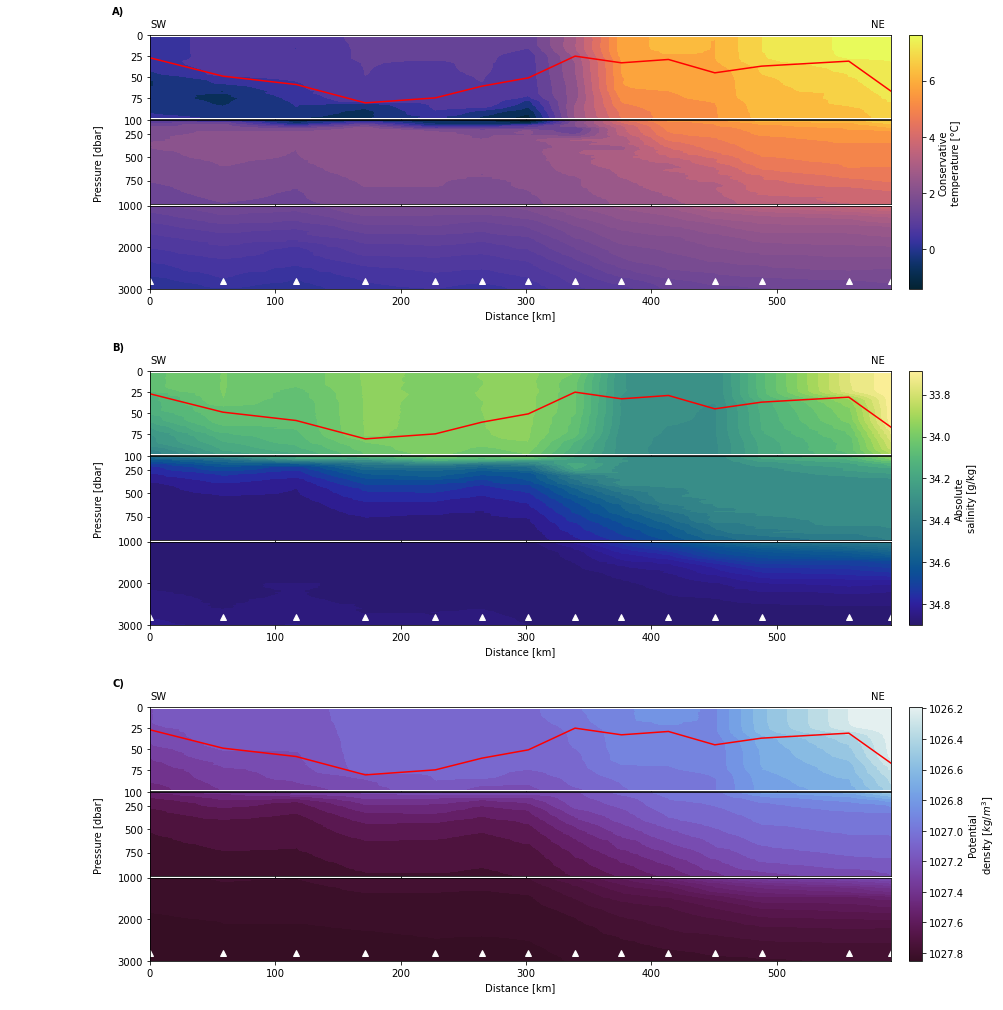

In [20]:
import cmocean as cmocean
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig = plt.figure(figsize=(16,14))

#Temperature plots
[temp, sal, dens] = fig.subfigures(3, 1)

[ax0_mld, ax0_mid, ax0_prof] = temp.subplots(3,1, sharex=True)
temp_mld = ax0_mld.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.PRES[0][:49]),
    np.array(ds.CT.sel({'MAXZ':slice(None,49)})).transpose(),
    cmap=cmocean.cm.thermal,
    levels = 20,
    vmin=np.min(np.array(ds.CT).transpose()),
    vmax=np.max(np.array(ds.CT).transpose())
)

temp_mid = ax0_mid.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.PRES[0][50:499]),
    np.array(ds.CT.sel({'MAXZ':slice(50,499)})).transpose(),
    cmap=cmocean.cm.thermal,
    levels = 20,
    vmin=np.min(np.array(ds.CT).transpose()),
    vmax=np.max(np.array(ds.CT).transpose())
)

temp_prof = ax0_prof.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.PRES[0][500:]),
    np.array(ds.CT.sel({'MAXZ':slice(500,None)})).transpose(),
    cmap=cmocean.cm.thermal,
    levels = 20,
    vmin=np.min(np.array(ds.CT).transpose()),
    vmax=np.max(np.array(ds.CT).transpose())
)

#Salinity plots
[ax1_mld, ax1_mid, ax1_prof] = sal.subplots(3,1, sharex=True)

sal_mld = ax1_mld.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.PRES[0][:49]),
    np.array(ds.SA.sel({'MAXZ':slice(None,49)})).transpose(),
    cmap=cmocean.cm.haline_r,
    levels = 20,
    vmin=np.min(np.array(ds.SA).transpose()),
    vmax=np.max(np.array(ds.SA).transpose())
)

sal_mid = ax1_mid.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.PRES[0][50:499]),
    np.array(ds.SA.sel({'MAXZ':slice(50,499)})).transpose(),
    cmap=cmocean.cm.haline_r,
    levels = 20,
    vmin=np.min(np.array(ds.SA).transpose()),
    vmax=np.max(np.array(ds.SA).transpose())
)

sal_prof = ax1_prof.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.PRES[0][500:]),
    np.array(ds.SA.sel({'MAXZ':slice(500,None)})).transpose(),
    cmap=cmocean.cm.haline_r,
    levels=20,
    vmin=np.min(np.array(ds.SA).transpose()),
    vmax=np.max(np.array(ds.SA).transpose())
)

#Density plots
[ax2_mld, ax2_mid, ax2_prof] = dens.subplots(3,1, sharex=True)

rho_mld = ax2_mld.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.PRES[0][:49]),
    np.array(ds.p_rho.sel({'MAXZ':slice(None,49)})).transpose()-1000,
    cmap=cmocean.cm.dense,
    levels = 20,
    vmin=np.min(np.array(ds.p_rho).transpose())-1000,
    vmax=np.max(np.array(ds.p_rho).transpose())-1000
)

rho_mid = ax2_mid.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.PRES[0][50:499]),
    np.array(ds.p_rho.sel({'MAXZ':slice(50,499)})).transpose()-1000,
    cmap=cmocean.cm.dense,
    levels = 20,
    vmin=np.min(np.array(ds.p_rho).transpose())-1000,
    vmax=np.max(np.array(ds.p_rho).transpose())-1000
)

rho_prof = ax2_prof.contourf(
    np.array(ds.distance_cum)/1000, 
    np.array(ds.PRES[0][500:]), 
    np.array(ds.p_rho.sel({'MAXZ':slice(500,None)})).transpose()-1000,
    cmap=cmocean.cm.dense,
    levels = 20,
    vmin=np.min(np.array(ds.p_rho).transpose())-1000,
    vmax=np.max(np.array(ds.p_rho).transpose())-1000
    )


#Additional stuff
for figure in [temp, sal, dens]:
    figure.text(0.08, 0.5, 'Pressure [dbar]', ha='center', va='center', rotation='vertical')
    figure.subplots_adjust(
        hspace=0.02
    )

def plot_stations(location,ax):
    ax.plot(        
        location, 
        2800,
        linestyle='None',
        marker='^',
        c='white')

def plot_direction(ax):
    ax.text(0, -10, 'SW')
    ax.text(575, -10, 'NE')


axes_MLD = [ax0_mld, ax1_mld, ax2_mld]
for ax in axes_MLD:
    ax.invert_yaxis()

    title = {ax0_mld:'A)', ax1_mld:'B)', ax2_mld:'C)'}
    ax.text(-30, -25, title[ax], fontweight='bold')

    ticks_mld=[0,25,50,75]
    ax.set_ylim((100,0))
    ax.set_yticks(ticks_mld)

    ax.tick_params(which='major', left=True, color='black')

    #MLD
    plot_direction(ax)
    ax.plot(
        np.array(ds.distance_cum)/1000,
        MLD_pres_9,
        c='red')

axes_mid = [ax0_mid, ax1_mid, ax2_mid]
for ax in axes_mid:
    ticks_mid=[100,250,500,750]
    ax.set_ylim((1000,100))
    ax.set_yticks(ticks_mid)

    ax.tick_params(which='major', left=True, color='black')

axes_prof = [ax0_prof, ax1_prof, ax2_prof]
for ax in axes_prof:
    ax.set_ylim((3000,1000))
    ticks_prof = [1000,2000,3000]
    ax.set_yticks(ticks_prof)

    ax.set_xlabel('Distance [km]')

    for i in range((len(distance_cum))):
        plot_stations(np.array(ds.distance_cum[i]/1000),ax)

    ax.tick_params(which='major', left=True, color='black')

cb_temp = temp.colorbar(mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=np.min(np.array(ds.CT).transpose()), vmax=np.max(np.array(ds.CT).transpose())), cmap=cmocean.cm.thermal), 
    ax=[ax0_mld, ax0_mid, ax0_prof],
    label='Conservative\ntemperature [°C]',
    pad=0.02)
cb_sal = sal.colorbar(mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=np.min(np.array(ds.SA).transpose()), vmax=np.max(np.array(ds.SA).transpose())), cmap=cmocean.cm.haline_r), 
    ax=[ax1_mld, ax1_mid, ax1_prof],
    label='Absolute\nsalinity [g/kg]',
    pad=0.02)
cb_sal.ax.invert_yaxis()
cb_dens = dens.colorbar(mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=np.min(np.array(ds.p_rho).transpose()), vmax=np.max(np.array(ds.p_rho).transpose())), cmap=cmocean.cm.dense),  
    ax=[ax2_mld, ax2_mid, ax2_prof],
    label='Potential\ndensity $[kg/m^{3}]$',
    pad=0.02)
cb_dens.ax.invert_yaxis()

plt.show()
fig.savefig('results/analysis/orchestra_2/CTD_casts_TSDens_pres.png', bbox_inches='tight', format='png')

## Calculation of MLD referenced to depth

In [21]:
ds

<xarray.Dataset>
Dimensions:                 (N_profile: 14, MAXZ: 1500)
Coordinates:
    LATITUDE                (N_profile) float64 -60.0 -59.5 ... -55.21 -55.52
    LONGITUDE               (N_profile) float64 -55.24 -55.55 ... -57.98 -57.98
    PRES                    (N_profile, MAXZ) float32 3.0 5.0 ... 3.005e+03
    TIME                    (N_profile) object 2017-12-02 21:09:39 ... 2017-1...
Dimensions without coordinates: N_profile, MAXZ
Data variables: (12/40)
    SDN_CRUISE              (N_profile) |S80 b'JR17001 (ORCHESTRA)' ... b'JR1...
    crs                     (N_profile) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    SDN_EDMO_CODE           (N_profile) int32 43 43 43 43 43 ... 43 43 43 43 43
    SDN_STATION             (N_profile) |S80 b'CTD_JR17001_031_2DB' ... b'CTD...
    SDN_LOCAL_CDI_ID        (N_profile) |S80 b'1841282' ... b'1841405'
    SDN_BOT_DEPTH           (N_profile) float64 3.514e+03 ... 4.278e+03
    ...                      ...
    TOKGPR01                (N_profile, MAXZ) float32 0.9735 0.9735 ... 0.973
    SA                      (N_profile, MAXZ) float64 34.05 34.05 ... 34.89
    CT                      (N_profile, MAXZ) float64 0.2064 0.2051 ... 1.474
    p_rho                   (N_profile, MAXZ) float64 1.027e+03 ... 1.028e+03
    distance_cum            (N_profile) float64 0.0 5.818e+04 ... 5.911e+05
    DEPTH                   (N_profile, MAXZ) float64 2.972 4.953 ... 2.957e+03
Attributes:
    date_update:  2020-04-06T02:30:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  profile
    title:        SeaDataNet NETCDF PROFILE Climate Forecast 1.6 - GENERATED ...

In [22]:
df_rho_10 = []
for i in range(len(df.loc[(slice(None),0), :].DEPTH)):
    df_rho_10.append(df.where(df['DEPTH'] == utils.utils.closest_value(ds.DEPTH[i],10)).dropna()['p_rho'] )
df_rho_10 = np.array(df_rho_10)

MLD_depth_10 = []
for i in range(len(df.loc[(slice(None),0), :])):
    MLD_depth_10.append(df['DEPTH'][i].where(df['p_rho'][i] > float((df_rho_10[i] + 0.03))).dropna().iloc[0])
MLD_depth_10 = pd.DataFrame({'MLD [m]':MLD_depth_10,'Longitude':np.array(ds.LONGITUDE),'Latitude':np.array(ds.LATITUDE)}, index=ds.N_profile, )


In [23]:
MLD_depth_10.to_pickle('data/04_models/tsg_orchestra_2/MLD.pkl')

## Vertical section plot (whole depth)

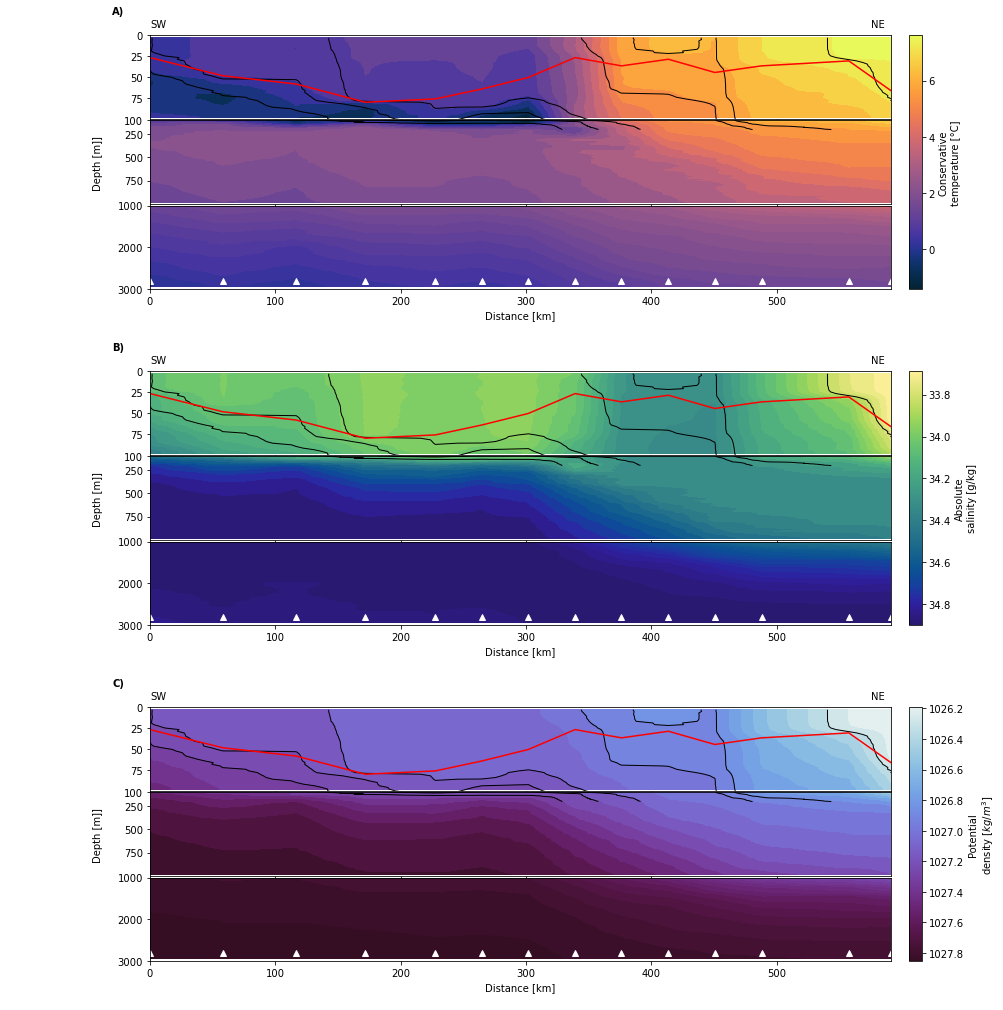

In [24]:
import cmocean as cmocean
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig = plt.figure(figsize=(16,14))

#Temperature plots
[temp, sal, dens] = fig.subfigures(3, 1)

[ax0_mld, ax0_mid, ax0_prof] = temp.subplots(3,1, sharex=True)
temp_mld = ax0_mld.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][:49]),
    np.array(ds.CT.sel({'MAXZ':slice(None,49)})).transpose(),
    cmap=cmocean.cm.thermal,
    levels = 20,
    vmin=np.min(np.array(ds.CT).transpose()),
    vmax=np.max(np.array(ds.CT).transpose())
)

temp_mid = ax0_mid.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][50:499]),
    np.array(ds.CT.sel({'MAXZ':slice(50,499)})).transpose(),
    cmap=cmocean.cm.thermal,
    levels = 20,
    vmin=np.min(np.array(ds.CT).transpose()),
    vmax=np.max(np.array(ds.CT).transpose())
)

temp_prof = ax0_prof.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][500:]),
    np.array(ds.CT.sel({'MAXZ':slice(500,None)})).transpose(),
    cmap=cmocean.cm.thermal,
    levels = 20,
    vmin=np.min(np.array(ds.CT).transpose()),
    vmax=np.max(np.array(ds.CT).transpose())
)

#Salinity plots
[ax1_mld, ax1_mid, ax1_prof] = sal.subplots(3,1, sharex=True)

sal_mld = ax1_mld.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][:49]),
    np.array(ds.SA.sel({'MAXZ':slice(None,49)})).transpose(),
    cmap=cmocean.cm.haline_r,
    levels = 20,
    vmin=np.min(np.array(ds.SA).transpose()),
    vmax=np.max(np.array(ds.SA).transpose())
)

sal_mid = ax1_mid.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][50:499]),
    np.array(ds.SA.sel({'MAXZ':slice(50,499)})).transpose(),
    cmap=cmocean.cm.haline_r,
    levels = 20,
    vmin=np.min(np.array(ds.SA).transpose()),
    vmax=np.max(np.array(ds.SA).transpose())
)

sal_prof = ax1_prof.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][500:]),
    np.array(ds.SA.sel({'MAXZ':slice(500,None)})).transpose(),
    cmap=cmocean.cm.haline_r,
    levels=20,
    vmin=np.min(np.array(ds.SA).transpose()),
    vmax=np.max(np.array(ds.SA).transpose())
)

#Density plots
[ax2_mld, ax2_mid, ax2_prof] = dens.subplots(3,1, sharex=True)

rho_mld = ax2_mld.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][:49]),
    np.array(ds.p_rho.sel({'MAXZ':slice(None,49)})).transpose()-1000,
    cmap=cmocean.cm.dense,
    levels = 20,
    vmin=np.min(np.array(ds.p_rho).transpose())-1000,
    vmax=np.max(np.array(ds.p_rho).transpose())-1000
)

rho_mid = ax2_mid.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][50:499]),
    np.array(ds.p_rho.sel({'MAXZ':slice(50,499)})).transpose()-1000,
    cmap=cmocean.cm.dense,
    levels = 20,
    vmin=np.min(np.array(ds.p_rho).transpose())-1000,
    vmax=np.max(np.array(ds.p_rho).transpose())-1000
)

rho_prof = ax2_prof.contourf(
    np.array(ds.distance_cum)/1000, 
    np.array(ds.DEPTH[0][500:]), 
    np.array(ds.p_rho.sel({'MAXZ':slice(500,None)})).transpose()-1000,
    cmap=cmocean.cm.dense,
    levels = 20,
    vmin=np.min(np.array(ds.p_rho).transpose())-1000,
    vmax=np.max(np.array(ds.p_rho).transpose())-1000
    )


#Additional stuff
for figure in [temp, sal, dens]:
    figure.text(0.08, 0.5, 'Depth [m]]', ha='center', va='center', rotation='vertical')
    figure.subplots_adjust(
        hspace=0.02
    )

def plot_stations(location,ax):
    ax.plot(        
        location, 
        2800,
        linestyle='None',
        marker='^',
        c='white')

def plot_direction(ax):
    ax.text(0, -10, 'SW')
    ax.text(575, -10, 'NE')


axes_MLD = [ax0_mld, ax1_mld, ax2_mld]
for ax in axes_MLD:
    ax.invert_yaxis()

    title = {ax0_mld:'A)', ax1_mld:'B)', ax2_mld:'C)'}
    ax.text(-30, -25, title[ax], fontweight='bold')

    ticks_mld=[0,25,50,75]
    ax.set_ylim((100,0))
    ax.set_yticks(ticks_mld)

    ax.tick_params(which='major', left=True, color='black')

    #MLD
    plot_direction(ax)
    ax.plot(
        np.array(ds.distance_cum)/1000,
        MLD_depth_10,
        c='red')

    dens_con = ax.contour(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][:100]),
    np.array(ds.p_rho.sel({'MAXZ':slice(None,100)})).transpose(),
    colors='black',
    levels=[1026.32, 1026.88, 1026.96, 1027.12, 1027.20, 1027.28],
    linewidths=1
    )
    #ax.clabel(dens_con, dens_con.levels, inline=True, fontsize=10)

axes_mid = [ax0_mid, ax1_mid, ax2_mid]
for ax in axes_mid:
    ticks_mid=[100,250,500,750]
    ax.set_ylim((1000,100))
    ax.set_yticks(ticks_mid)

    ax.tick_params(which='major', left=True, color='black')

    dens_con = ax.contour(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][:100]),
    np.array(ds.p_rho.sel({'MAXZ':slice(None,100)})).transpose(),
    colors='black',
    levels=[1026.32, 1026.88, 1026.96, 1027.12, 1027.20, 1027.28],
    linewidths=1
    )

axes_prof = [ax0_prof, ax1_prof, ax2_prof]
for ax in axes_prof:
    ax.set_ylim((3000,1000))
    ticks_prof = [1000,2000,3000]
    ax.set_yticks(ticks_prof)

    ax.set_xlabel('Distance [km]')

    for i in range((len(distance_cum))):
        plot_stations(np.array(ds.distance_cum[i]/1000),ax)

    ax.tick_params(which='major', left=True, color='black')

    # dens_con = ax.contour(
    # np.array(ds.distance_cum)/1000,
    # np.array(ds.DEPTH[0][:100]),
    # np.array(ds.p_rho.sel({'MAXZ':slice(None,100)})).transpose(),
    # colors='black',
    # levels=[1026.32, 1026.88, 1026.96, 1027.12, 1027.20, 1027.28],
    # linewidths=1
    # )

cb_temp = temp.colorbar(mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=np.min(np.array(ds.CT).transpose()), vmax=np.max(np.array(ds.CT).transpose())), cmap=cmocean.cm.thermal), 
    ax=[ax0_mld, ax0_mid, ax0_prof],
    label='Conservative\ntemperature [°C]',
    pad=0.02)
cb_sal = sal.colorbar(mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=np.min(np.array(ds.SA).transpose()), vmax=np.max(np.array(ds.SA).transpose())), cmap=cmocean.cm.haline_r), 
    ax=[ax1_mld, ax1_mid, ax1_prof],
    label='Absolute\nsalinity [g/kg]',
    pad=0.02)
cb_sal.ax.invert_yaxis()
cb_dens = dens.colorbar(mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=np.min(np.array(ds.p_rho).transpose()), vmax=np.max(np.array(ds.p_rho).transpose())), cmap=cmocean.cm.dense),  
    ax=[ax2_mld, ax2_mid, ax2_prof],
    label='Potential\ndensity $[kg/m^{3}]$',
    pad=0.02)
cb_dens.ax.invert_yaxis()

plt.show()
fig.savefig('results/analysis/orchestra_2/CTD_casts_TSDens_depth.png', bbox_inches='tight', format='png')

## Vertical section (first few hundreds m)

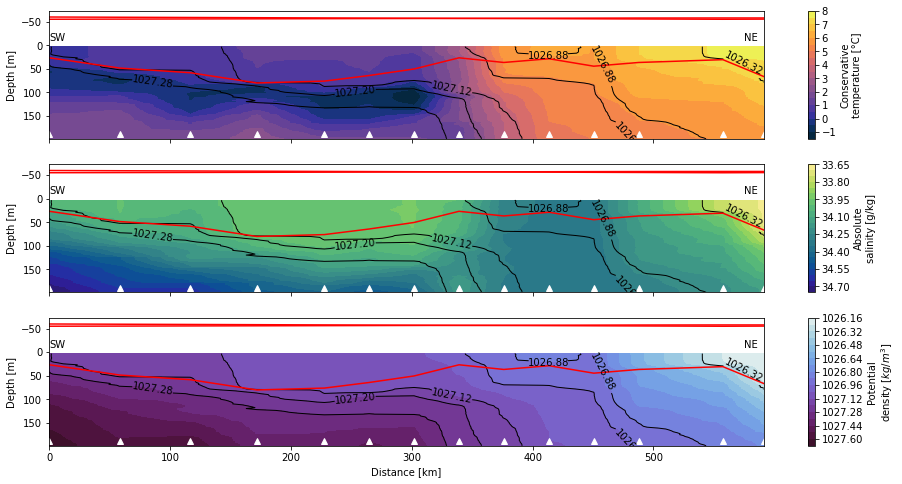

In [25]:
import cmocean
fig = plt.figure(figsize=(16,8))
[ax0, ax1, ax2] = fig.subplots(nrows=3, sharex=True)

temp = ax0.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][:100]),
    np.array(ds.CT.sel({'MAXZ':slice(None,100)})).transpose(),
    cmap=cmocean.cm.thermal,
    levels=20
)

sal = ax1.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][:100]),
    np.array(ds.SA.sel({'MAXZ':slice(None,100)})).transpose(),
    cmap=cmocean.cm.haline_r,
    levels=20
)

dens = ax2.contourf(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][:100]),
    np.array(ds.p_rho.sel({'MAXZ':slice(None,100)})).transpose(),
    cmap=cmocean.cm.dense,
    levels=20
)

def plot_stations(location,ax):
    ax.plot(        
        location, 
        np.max(ds.DEPTH[0][:95]),
        linestyle='None',
        marker='^',
        c='white')

def plot_direction(ax):
    ax.text(0, -10, 'SW')
    ax.text(575, -10, 'NE')

axes = [ax0, ax1, ax2]
for ax in axes:
    ax.invert_yaxis()
    for i in range((len(distance_cum))):
        plot_stations(np.array(ds.distance_cum[i]/1000),ax)

    plot_direction(ax)
    ax.plot(
        np.array(ds.distance_cum)/1000,
        MLD_depth_10,
        c='red')

    ax.set_ylabel('Depth [m]')

    dens_con = ax.contour(
    np.array(ds.distance_cum)/1000,
    np.array(ds.DEPTH[0][:100]),
    np.array(ds.p_rho.sel({'MAXZ':slice(None,100)})).transpose(),
    colors='black',
    levels=[1026.32, 1026.88, 1026.96, 1027.12, 1027.20, 1027.28],
    linewidths=1
    )

    ax.clabel(dens_con, dens_con.levels, inline=True, fontsize=10)

cb_temp = plt.colorbar(temp, 
    ax=ax0,
    label='Conservative\ntemperature [°C]',)
cb_sal = plt.colorbar(sal, 
    ax=ax1,
    label='Absolute\nsalinity [g/kg]')
cb_sal.ax.invert_yaxis()
cb_dens = plt.colorbar(dens, 
    ax=ax2,
    label='Potential\ndensity $[kg/m^{3}]$')
cb_dens.ax.invert_yaxis()

ax2.set_xlabel('Distance [km]')
fig.savefig('results/analysis/orchestra_2/CTD_casts_ML_depth.png', bbox_inches='tight', format='png')

# TS plots

In [26]:
ds

<xarray.Dataset>
Dimensions:                 (N_profile: 14, MAXZ: 1500)
Coordinates:
    LATITUDE                (N_profile) float64 -60.0 -59.5 ... -55.21 -55.52
    LONGITUDE               (N_profile) float64 -55.24 -55.55 ... -57.98 -57.98
    PRES                    (N_profile, MAXZ) float32 3.0 5.0 ... 3.005e+03
    TIME                    (N_profile) object 2017-12-02 21:09:39 ... 2017-1...
Dimensions without coordinates: N_profile, MAXZ
Data variables: (12/40)
    SDN_CRUISE              (N_profile) |S80 b'JR17001 (ORCHESTRA)' ... b'JR1...
    crs                     (N_profile) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0
    SDN_EDMO_CODE           (N_profile) int32 43 43 43 43 43 ... 43 43 43 43 43
    SDN_STATION             (N_profile) |S80 b'CTD_JR17001_031_2DB' ... b'CTD...
    SDN_LOCAL_CDI_ID        (N_profile) |S80 b'1841282' ... b'1841405'
    SDN_BOT_DEPTH           (N_profile) float64 3.514e+03 ... 4.278e+03
    ...                      ...
    TOKGPR01                (N_profile, MAXZ) float32 0.9735 0.9735 ... 0.973
    SA                      (N_profile, MAXZ) float64 34.05 34.05 ... 34.89
    CT                      (N_profile, MAXZ) float64 0.2064 0.2051 ... 1.474
    p_rho                   (N_profile, MAXZ) float64 1.027e+03 ... 1.028e+03
    distance_cum            (N_profile) float64 0.0 5.818e+04 ... 5.911e+05
    DEPTH                   (N_profile, MAXZ) float64 2.972 4.953 ... 2.957e+03
Attributes:
    date_update:  2020-04-06T02:30:54+0100
    comment:      
    Conventions:  SeaDataNet_1.0 CF-1.6
    featureType:  profile
    title:        SeaDataNet NETCDF PROFILE Climate Forecast 1.6 - GENERATED ...

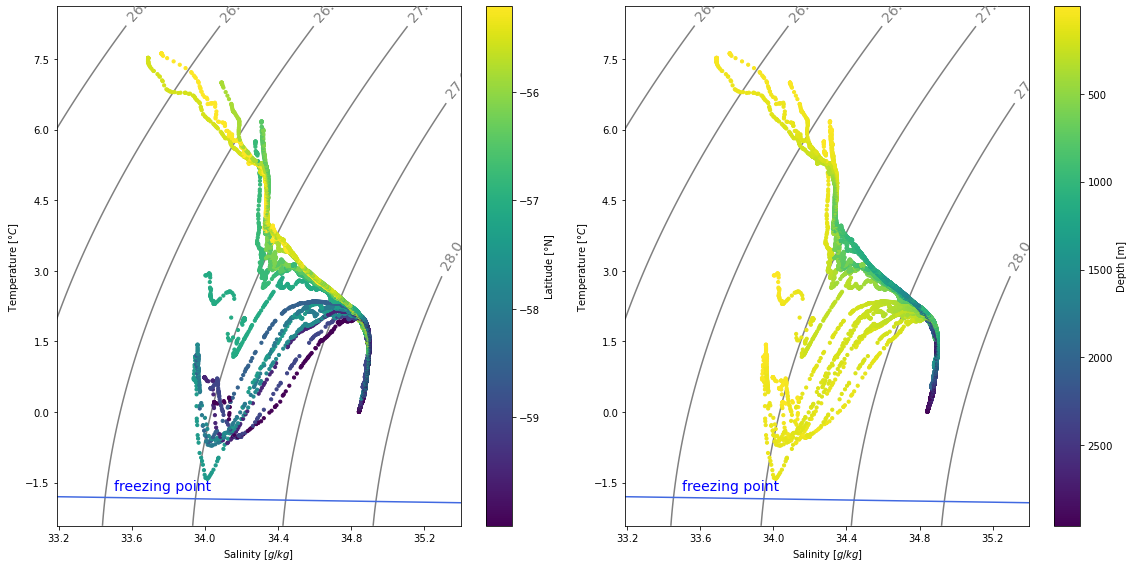

In [27]:
from matplotlib.ticker import MaxNLocator
import cmocean.cm as cm

df = ds.to_dataframe()

ts = df[['CT','SA','LATITUDE','DEPTH']]

df = ts.sort_values('CT',ascending=True)

mint = np.min(df['CT'])
maxt = np.max(df['CT'])

mins = np.min(df['SA'])
maxs = np.max(df['SA'])

tempL = np.linspace(mint-1,maxt+1,len(df))

salL = np.linspace(mins-0.5,maxs+0.5,len(df))

Tg, Sg = np.meshgrid(tempL,salL)
sigma_theta =gsw.sigma0(Sg,Tg)
cnt = np.linspace(sigma_theta.min(),sigma_theta.max(),len(df))

#-----------------------------------------------------------------------------#

fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(16,8))

#-----------------------------------------------------------------------------#

#ax0
cs = ax0.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1)
cl = plt.clabel(cs, fontsize=14, inline=True, fmt='%.1f')

sc = ax0.scatter(df['SA'], df['CT'], c=df['LATITUDE'], s=10)
fp = ax0.plot(salL, gsw.CT_freezing(salL, 0, 0), color='royalblue')
cb = plt.colorbar(sc, ax=ax0)

ax0.set(xlabel='Salinity [$g/kg$]', ylabel='Temperature [$°C$]')
ax0.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax0.yaxis.set_major_locator(MaxNLocator(nbins=8))
ax0.tick_params(direction='out')
#cb.set_label('Density [kg m$^{-3}$]')
cb.set_label('Latitude [°N]')

#-----------------------------------------------------------------------------#

#ax1
# cs = ax1.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1)
# cl = plt.clabel(cs, fontsize=14, inline=True, fmt='%.1f')

# sc = ax1.scatter(df['SA'], df['CT'], c=cnt, s=10)
# fp = ax1.plot(salL, gsw.CT_freezing(salL, 0, 0), color='royalblue')
# cb = plt.colorbar(sc, ax=ax0)

# ax1.set(xlabel='Salinity [$g/kg$]', ylabel='Temperature [$°C$]')
# ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))
# ax1.yaxis.set_major_locator(MaxNLocator(nbins=8))
# ax1.tick_params(direction='out')
# cb.set_label('Density [kg m$^{-3}$]')
# #cb.set_label('Latitude [°N]')

#-----------------------------------------------------------------------------#

#ax1
cs = ax1.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1)
cl = plt.clabel(cs, fontsize=14, inline=True, fmt='%.1f')

sc = ax1.scatter(df['SA'], df['CT'], c=df['DEPTH'], cmap='viridis_r', s=10)
fp = ax1.plot(salL, gsw.CT_freezing(salL, 0, 0), color='royalblue')
cb = plt.colorbar(sc, ax=ax1)

ax1.set(xlabel='Salinity [$g/kg$]', ylabel='Temperature [$°C$]')
ax1.xaxis.set_major_locator(MaxNLocator(nbins=6))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=8))
ax1.tick_params(direction='out')
#cb.set_label('Density [kg m$^{-3}$]')
#cb.set_label('Latitude [°N]')
cb.set_label('Depth [m]')
cb.ax.invert_yaxis()

#-----------------------------------------------------------------------------#

axes = [ax0,ax1]
for ax in axes: 
    freezestr = '\nfreezing point'
    ax.text(33.5, -1.4, 
    freezestr,
    color='blue', 
    #transform=ax.transAxes, 
    fontsize=14,
    verticalalignment='center')

#-----------------------------------------------------------------------------#



# SubantSurWatstr = '\nSubantartic Surface Water'
# ax.text(33.97, 4.0,
#     SubantSurWatstr,
#     color='black',
#     fontsize=14,
#     verticalalignment='center',
#     rotation=35)

# AntSurWatstr = '\nAntarctic Surface Water'
# ax.text(34.1, 1.5,
#     AntSurWatstr,
#     color='black',
#     fontsize=14,
#     verticalalignment='center')

#ConShelfWatstr = '\nContinental Shelf Water'
#ax.text(33.9, -0.1,
 #   ConShelfWatstr,
 #   color='black',
 #   fontsize=14,
 #   verticalalignment='center')

plt.tight_layout()
fig.savefig('results/analysis/orchestra_2/TS-plots-CTD-casts.png', bbox_inches='tight', format='png')